In [1]:
%matplotlib inline
import os
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cymr import cmr
from cymr import network
from cymr import parameters
from psifr import fr
from cfr import task
import importlib

cfr_dir = '/Users/morton/Dropbox/work/cmr_cfr/cfr'
data_file = os.path.join(cfr_dir, 'cfr_eeg_mixed.csv')
pattern_file = os.path.join(cfr_dir, 'cfr_patterns.hdf5')
#model_name = 'cmr_fcf-loc-cat_ff-use'
model_name = 'cmrs_fcf-loc-cat-use_sl-B_enc-B_rec_fix-B_rec_cat=1-B_rec_use=1'
fit_dir = os.path.join(cfr_dir, 'fits', 'v4', model_name)
param_file = os.path.join(fit_dir, 'parameters.json')

In [2]:
param_def = parameters.read_json(param_file)
results = pd.read_csv(os.path.join(fit_dir, 'fit.csv'), index_col=0)
subj_param = results.loc[1].to_dict()

In [3]:
patterns = network.load_patterns(pattern_file)
data = pd.read_csv(data_file)
labeled = task.label_clean_trials(data)
subj_data = fr.filter_data(labeled, subjects=1, lists=[9, 10])
subj_data

,subject,list,position,trial_type,item,item_index,session,list_type,category,response,response_time,list_category,clean
185,1,9,1,study,SMITHSONIAN CASTLE,455,1,mixed,loc,3.0,1.463,mixed,True
186,1,9,2,study,SKYDOME,454,1,mixed,loc,3.0,0.726,mixed,True
187,1,9,3,study,UMBRELLA,749,1,mixed,obj,4.0,0.618,mixed,True
188,1,9,4,study,DEODORANT,571,1,mixed,obj,3.0,0.498,mixed,True
189,1,9,5,study,BENJAMIN FRANKLIN,27,1,mixed,cel,2.0,0.542,mixed,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,1,10,4,recall,MATT DAMON,173,1,mixed,cel,4.0,0.727,mixed,True
250,1,10,5,recall,THE VENETIAN,475,1,mixed,loc,4.0,0.949,mixed,True
251,1,10,6,recall,STAPLE REMOVER,720,1,mixed,obj,3.0,1.106,mixed,True
252,1,10,7,recall,HIGHLIGHTER,612,1,mixed,obj,4.0,0.928,mixed,True


In [4]:
model = cmr.CMR()
state = model.record(
    subj_data, subj_param, param_def=param_def, patterns=patterns, include=['c', 'c_in']
)
print(f'data:  {len(subj_data.query("clean"))}')
print(f'state: {len(state)}')

data:  65
state: 65


In [5]:
clean_data = subj_data.query('clean')
study_inc = clean_data['trial_type'] == 'study'
study_data = clean_data.loc[study_inc]
c = np.array([s.c for s in state])
c_study = c[study_inc]
labels = study_data['category'].to_numpy()

In [6]:
print(study_data.shape)
print(c_study.shape)

(48, 13)
(48, 1286)


In [7]:
from sklearn import svm
train_inc = study_data['list'] == 9
test_inc = study_data['list'] == 10
clf = svm.SVC(probability=True)
clf.fit(c_study[train_inc], labels[train_inc])

SVC(probability=True)

In [8]:
clf.predict(c_study[test_inc])

array(['cel', 'cel', 'cel', 'loc', 'loc', 'obj', 'obj', 'obj', 'loc',
       'loc', 'cel', 'cel', 'cel', 'obj', 'obj', 'obj', 'loc', 'loc',
       'loc', 'loc', 'obj', 'obj', 'cel', 'cel'], dtype=object)

In [9]:
labels[test_inc]

array(['cel', 'cel', 'cel', 'loc', 'loc', 'obj', 'obj', 'obj', 'loc',
       'loc', 'cel', 'cel', 'cel', 'obj', 'obj', 'obj', 'loc', 'loc',
       'loc', 'loc', 'obj', 'obj', 'cel', 'cel'], dtype=object)

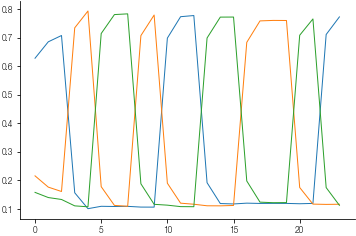

In [10]:
plt.plot(clf.predict_proba(c_study[test_inc]))

In [13]:
classes = clf.classes_

In [14]:
prob = clf.predict_proba(c_study[test_inc])

In [15]:
pd.DataFrame(prob, columns=classes)

,cel,loc,obj
0,0.627372,0.215262,0.157366
1,0.684873,0.175813,0.139313
2,0.706976,0.160485,0.132539
3,0.155957,0.733901,0.110142
4,0.100295,0.792837,0.106869
5,0.108627,0.177439,0.713934
6,0.107958,0.111723,0.780318
7,0.108434,0.108724,0.782842
8,0.105869,0.706656,0.187475
9,0.105717,0.778741,0.115542


In [37]:
np.nan == 4

False

In [65]:
from cfr import task
import importlib
importlib.reload(task)
category = labels[train_inc]
%pdb off
prev, base = task.get_train_category(category)
print(np.vstack([category, prev, base]).T)

Automatic pdb calling has been turned OFF
[['loc' '' '']
 ['loc' '' '']
 ['obj' 'loc' '']
 ['obj' 'loc' '']
 ['cel' 'obj' 'loc']
 ['cel' 'obj' 'loc']
 ['loc' 'cel' 'obj']
 ['loc' 'cel' 'obj']
 ['loc' 'cel' 'obj']
 ['loc' 'cel' 'obj']
 ['obj' 'loc' 'cel']
 ['obj' 'loc' 'cel']
 ['obj' 'loc' 'cel']
 ['obj' 'loc' 'cel']
 ['cel' 'obj' 'loc']
 ['cel' 'obj' 'loc']
 ['cel' 'obj' 'loc']
 ['cel' 'obj' 'loc']
 ['obj' 'cel' 'obj']
 ['obj' 'cel' 'obj']
 ['loc' 'obj' 'cel']
 ['loc' 'obj' 'cel']
 ['cel' 'loc' 'obj']
 ['cel' 'loc' 'obj']]


In [66]:
labeled = task.label_train_category(clean_data)
labeled

,subject,list,position,trial_type,item,item_index,session,list_type,category,response,response_time,list_category,clean,prev,base
185,1,9,1,study,SMITHSONIAN CASTLE,455,1,mixed,loc,3.0,1.463,mixed,True,NaN,NaN
186,1,9,2,study,SKYDOME,454,1,mixed,loc,3.0,0.726,mixed,True,NaN,NaN
187,1,9,3,study,UMBRELLA,749,1,mixed,obj,4.0,0.618,mixed,True,loc,NaN
188,1,9,4,study,DEODORANT,571,1,mixed,obj,3.0,0.498,mixed,True,loc,NaN
189,1,9,5,study,BENJAMIN FRANKLIN,27,1,mixed,cel,2.0,0.542,mixed,True,obj,loc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,1,10,2,recall,DOLLY PARTON,78,1,mixed,cel,4.0,0.601,mixed,True,NaN,NaN
249,1,10,4,recall,MATT DAMON,173,1,mixed,cel,4.0,0.727,mixed,True,NaN,NaN
250,1,10,5,recall,THE VENETIAN,475,1,mixed,loc,4.0,0.949,mixed,True,NaN,NaN
251,1,10,6,recall,STAPLE REMOVER,720,1,mixed,obj,3.0,1.106,mixed,True,NaN,NaN


In [64]:
labeled['prev'].astype('category')

185    NaN
186    NaN
187    loc
188    loc
189    obj
      ... 
247    NaN
249    NaN
250    NaN
251    NaN
252    NaN
Name: prev, Length: 65, dtype: category
Categories (3, object): [cel, loc, obj]

In [47]:
pd.Series(['a', 'b', 'c'], dtype='string')

0    a
1    b
2    c
dtype: string

In [51]:
labeled['prev'].astype('string')

185        
186        
187     loc
188     loc
189     obj
       ... 
247    <NA>
249    <NA>
250    <NA>
251    <NA>
252    <NA>
Name: prev, Length: 65, dtype: string

In [41]:
pd.__version__

'1.0.3'

In [19]:
labeled = study_data.copy()
for (subject, trial), list_data in study_data.groupby(['subject', 'list']):
    labeled.loc[list_data.index, 'new'] = list_data['list'].to_numpy() * 2
labeled

,subject,list,position,trial_type,item,item_index,session,list_type,category,response,response_time,list_category,clean,new
185,1,9,1,study,SMITHSONIAN CASTLE,455,1,mixed,loc,3.0,1.463,mixed,True,18.0
186,1,9,2,study,SKYDOME,454,1,mixed,loc,3.0,0.726,mixed,True,18.0
187,1,9,3,study,UMBRELLA,749,1,mixed,obj,4.0,0.618,mixed,True,18.0
188,1,9,4,study,DEODORANT,571,1,mixed,obj,3.0,0.498,mixed,True,18.0
189,1,9,5,study,BENJAMIN FRANKLIN,27,1,mixed,cel,2.0,0.542,mixed,True,18.0
190,1,9,6,study,DAN RATHER,65,1,mixed,cel,3.0,0.634,mixed,True,18.0
191,1,9,7,study,VIENNA,492,1,mixed,loc,3.0,0.751,mixed,True,18.0
192,1,9,8,study,PLACE DE LA CONCORDE,424,1,mixed,loc,3.0,0.705,mixed,True,18.0
193,1,9,9,study,GREAT SALT LAKE,338,1,mixed,loc,2.0,0.716,mixed,True,18.0
194,1,9,10,study,SIENA,451,1,mixed,loc,3.0,0.579,mixed,True,18.0


In [22]:
from psifr import fr

In [21]:
clf = svm.SVC(probability=True)
curr = np.zeros(len(labels))
prev = np.zeros(len(labels))
base = np.zeros(len(labels))
for train, test in logo.split(c_study, labels, groups):
    clf.fit(c_study[train], labels[train])
    x = clf.predict_proba(c_study[test])
    print(x)

NameError: name 'logo' is not defined

> <ipython-input-21-ea526f168f84>(5)<module>()
      3 prev = np.zeros(len(labels))
      4 base = np.zeros(len(labels))
----> 5 for train, test in logo.split(c_study, labels, groups):
      6     clf.fit(c_study[train], labels[train])
      7     x = clf.predict_proba(c_study[test])



ipdb>  q


In [ ]:
help(logo.split)

In [ ]:
from sklearn import model_selection as ms
groups = study_data['list'].to_numpy()
logo = ms.LeaveOneGroupOut()
clf = svm.SVC(probability=True)
res = ms.cross_validate(clf, c_study, labels, groups=groups, cv=logo)

In [ ]:
res

In [ ]:
help(svm.SVC)

In [ ]:
subj_data.loc[subj_data['clean'], 'state'] = state

In [ ]:
subj_data

In [ ]:
net = state[0]
c = np.empty((subj_data.shape[0], net.n_c))
c[:] = np.nan
for i, trial_state in enumerate(subj_data['state'].to_list()):
    if isinstance(trial_state, float):
        continue
    c[i, :] = trial_state.c
#pd.concat((subj_data, ))

In [ ]:
plt.matshow(c)
c.shape

In [ ]:
pd.concat((subj_data, c))

In [ ]:
c = np.array([s.c for s in state])
fig, ax = plt.subplots()
ax.matshow(c);

In [ ]:
fig, ax = plt.subplots()
segment_ind = state[0].get_segment('c', 'cat', 'item')
ind = slice(*tuple(segment_ind))
ax.plot(c[:23, ind]);

In [ ]:
segment_ind = state[0].get_segment('c', 'use', 'item')
ind = slice(*tuple(segment_ind))
fig, ax = plt.subplots(figsize=(12, 6))
ax.matshow(c[:23, ind]);

In [ ]:
ind1 = fr.filter_data(subj_data, lists=[9], trial_type='study').index
rel_ind1 = np.nonzero(subj_data.index.isin(ind1))
ind2 = fr.filter_data(subj_data, lists=[10], trial_type='study').index
rel_ind2 = np.nonzero(subj_data.index.isin(ind2))

In [ ]:
state_array = np.asarray(state)
state1 = np.array([s.c[ind] for s in state_array[rel_ind1]])
state2 = np.array([s.c[ind] for s in state_array[rel_ind2]])

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(16, 4))
ax[0].matshow(state1)
ax[1].matshow(state2)

In [ ]:
plt.matshow(1 - sd.squareform(sd.pdist(state1, 'correlation')))
plt.colorbar()

In [ ]:
plt.matshow(1 - sd.squareform(sd.pdist(state2, 'correlation')))
plt.colorbar()

In [ ]:
fig, ax = plt.subplots()
ax.matshow(patterns['vector']['use'])

In [ ]:
import scipy.spatial.distance as sd
plt.matshow(sd.squareform(sd.pdist(patterns['vector']['use'], 'euclidean')))

In [ ]:
from sklearn.svm import LinearSVC
cls = LinearSVC()
cls.train(state1)

In [ ]:
c_list = []
for i, state in sub_data['state'].items():
    if isinstance(state, float):
        continue
    c_list.append(state.c)
c = np.array(c_list)
c.shape

In [ ]:
lists = subj_data['list'].unique()
data_len = []
state_len = []
for l in lists:
    sub_data = fr.filter_data(subj_data, lists=l)
    state = model.record(sub_data, subj_param, param_def=param_def, patterns=patterns)
    data_len.append(len(sub_data))
    state_len.append(len(state))

In [ ]:
pd.DataFrame({'data': data_len, 'state': state_len}, index=lists)

In [ ]:
len(state)